<a href="https://colab.research.google.com/github/Just1got/ITMO_DPO_Machine_learning/blob/main/%D0%98%D0%A2%D0%9C%D0%9E_%D0%94%D0%9F%D0%9E_%D0%9F%D0%BE%D0%BB%D1%8F%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ИТМО ДПО**

---


**Выпускная квалификационная работа**
---
Разработка алгоритма распознавания языка жестов с использованием методов искусственного интеллекта
---
Поляков Дмитрий

# Нейронная сеть на данных ASL MNIST (Kaggle)

In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Просмотр загруженных в 'input' файлов

input/american_sign_language.PNG
input/sign_mnist_train.csv
input/sign_mnist_test.csv


Подключение необходимых для работы библиотек

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Загрузка ASL датасета для обучения нейронной сети



In [ ]:
train_df = pd.read_csv("input/sign_mnist_train.csv")
test_df = pd.read_csv("input/sign_mnist_test.csv")

In [ ]:
test = pd.read_csv("input/sign_mnist_test.csv")
#Переменная в которых будем хранить ответы на тестовую выборку
y = test['label']

Выведем первые 5 строк датасета

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

In [ ]:
x_train = train_df.values
x_test = test_df.values

Проведем нормирование оттенков серого, чтобы уменьшить влияние различий в освещении. Более того, CNN сходится быстрее на данных [0..1], чем на [0..255].

In [ ]:
# Normalize the data
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

Посмотрим на первые 10 изображений

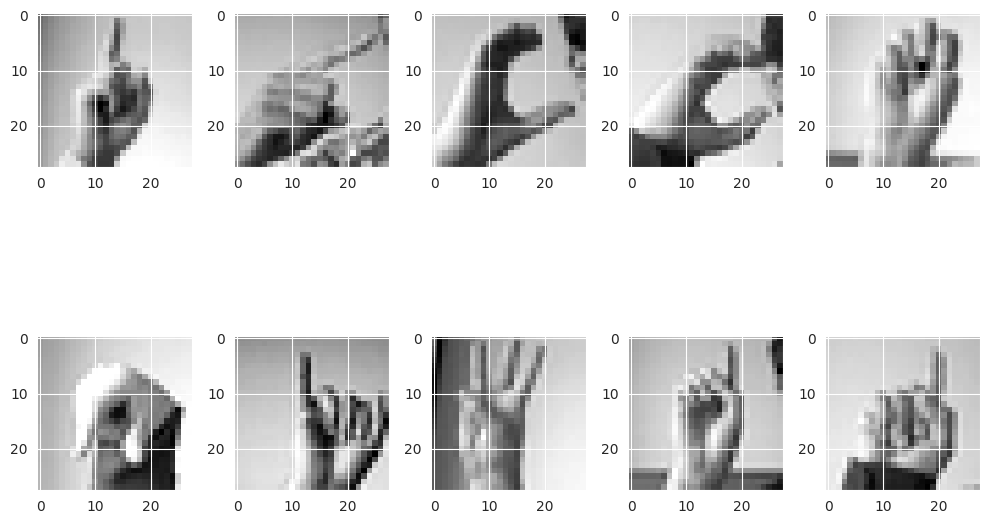

In [ ]:
f, ax = plt.subplots(2,5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(x_train[k].reshape(28, 28) , cmap = "gray")
        k += 1
    plt.tight_layout()

##Аугментация данных

Чтобы избежать проблемы переобучения, необходимо искусственно расширить набор данных. Идея состоит в том, чтобы изменить обучающие данные с помощью небольших преобразований, чтобы воспроизвести изменения.

Подходы, которые изменяют обучающие данные таким образом, чтобы изменить представление массива, сохраняя при этом метку, известны как методы аугментации. Некоторые популярные дополнения, которые люди используют, — это оттенки серого, горизонтальное отражение, вертикальное отражение, случайное кадрирование, дрожание цвета, переводы, повороты и многое другое.

Применив всего пару этих преобразований к обучающим данным, можно легко удвоить или утроить количество обучающих примеров и создать очень надежную модель.

In [ ]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

Случайным образом повернуты некоторые обучающие изображения на 10 градусов. Случайным образом увеличены некоторые обучающие изображения на 10 %. Произвольно смещены изображения по горизонтали на 10 % ширины. Произвольно сдвинуты изображения по вертикали на 10 % высоты.

##Обучение модели

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model = Sequential()
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(50 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(25 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 512 , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 24 , activation = 'softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

Для построения графиков будем хранить историю обучения модели

In [ ]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 128) ,epochs = 20 , validation_data = (x_test, y_test) , callbacks = [learning_rate_reduction])

Epoch 1/20
215/215 [==============================] - 116s 520ms/step - loss: 1.0577 - accuracy: 0.6684 - val_loss: 3.5072 - val_accuracy: 0.0657 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 116s 540ms/step - loss: 0.2076 - accuracy: 0.9302 - val_loss: 1.0242 - val_accuracy: 0.6520 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 116s 541ms/step - loss: 0.1022 - accuracy: 0.9677 - val_loss: 0.0593 - val_accuracy: 0.9897 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 111s 514ms/step - loss: 0.0621 - accuracy: 0.9795 - val_loss: 0.0770 - val_accuracy: 0.9753 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9858
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
215/215 [==============================] - 111s 518ms/step - loss: 0.0443 - accuracy: 0.9858 - val_loss: 0.2124 - val_accuracy: 0.9292 - lr: 0.0010
Epoch 6/20
215/215 [========================

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 11s 49ms/step - loss: 4.7362e-04 - accuracy: 1.0000
Accuracy of the model is -  100.0 %


##Анализ обученной модели

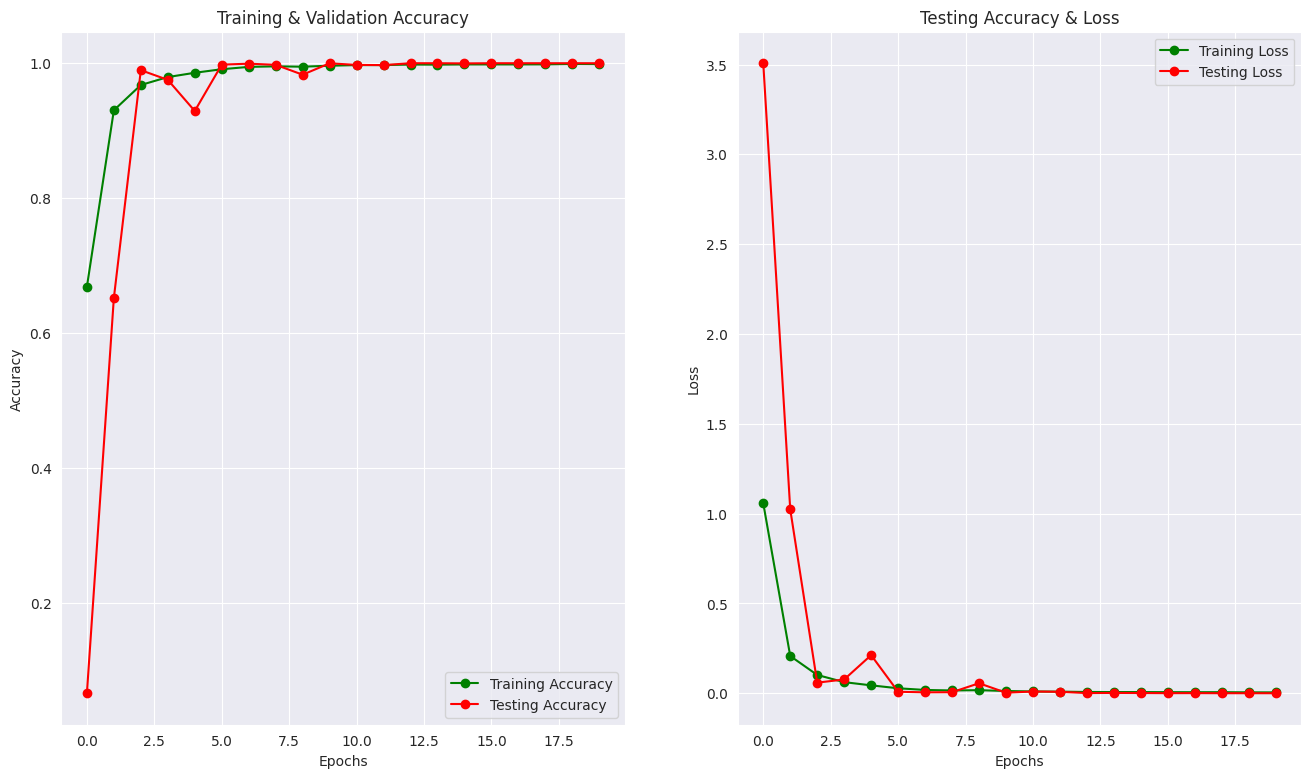

In [ ]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(16,9)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

Как видно из графиков модель быстро обучилась и уже к 12 эпохе имела 99% точность.

Сделаем прогноз модели на тестовых данных

In [ ]:
predictions = np.argmax(model.predict(x_test),axis=1)
for i in range(len(predictions)):
    if(predictions[i] >= 9):
        predictions[i] += 1
predictions[:5]

225/225 [==============================] - 10s 44ms/step


array([ 6,  5, 10,  0,  3])

In [ ]:
classes = ["Class " + str(i) for i in range(25) if i != 9]
print(classification_report(y, predictions, target_names = classes))

              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00       331
     Class 1       1.00      1.00      1.00       432
     Class 2       1.00      1.00      1.00       310
     Class 3       1.00      1.00      1.00       245
     Class 4       1.00      1.00      1.00       498
     Class 5       1.00      1.00      1.00       247
     Class 6       1.00      1.00      1.00       348
     Class 7       1.00      1.00      1.00       436
     Class 8       1.00      1.00      1.00       288
    Class 10       1.00      1.00      1.00       331
    Class 11       1.00      1.00      1.00       209
    Class 12       1.00      1.00      1.00       394
    Class 13       1.00      1.00      1.00       291
    Class 14       1.00      1.00      1.00       246
    Class 15       1.00      1.00      1.00       347
    Class 16       1.00      1.00      1.00       164
    Class 17       1.00      1.00      1.00       144
    Class 18       1.00    

Построим матрицу ошибок

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

<Axes: >

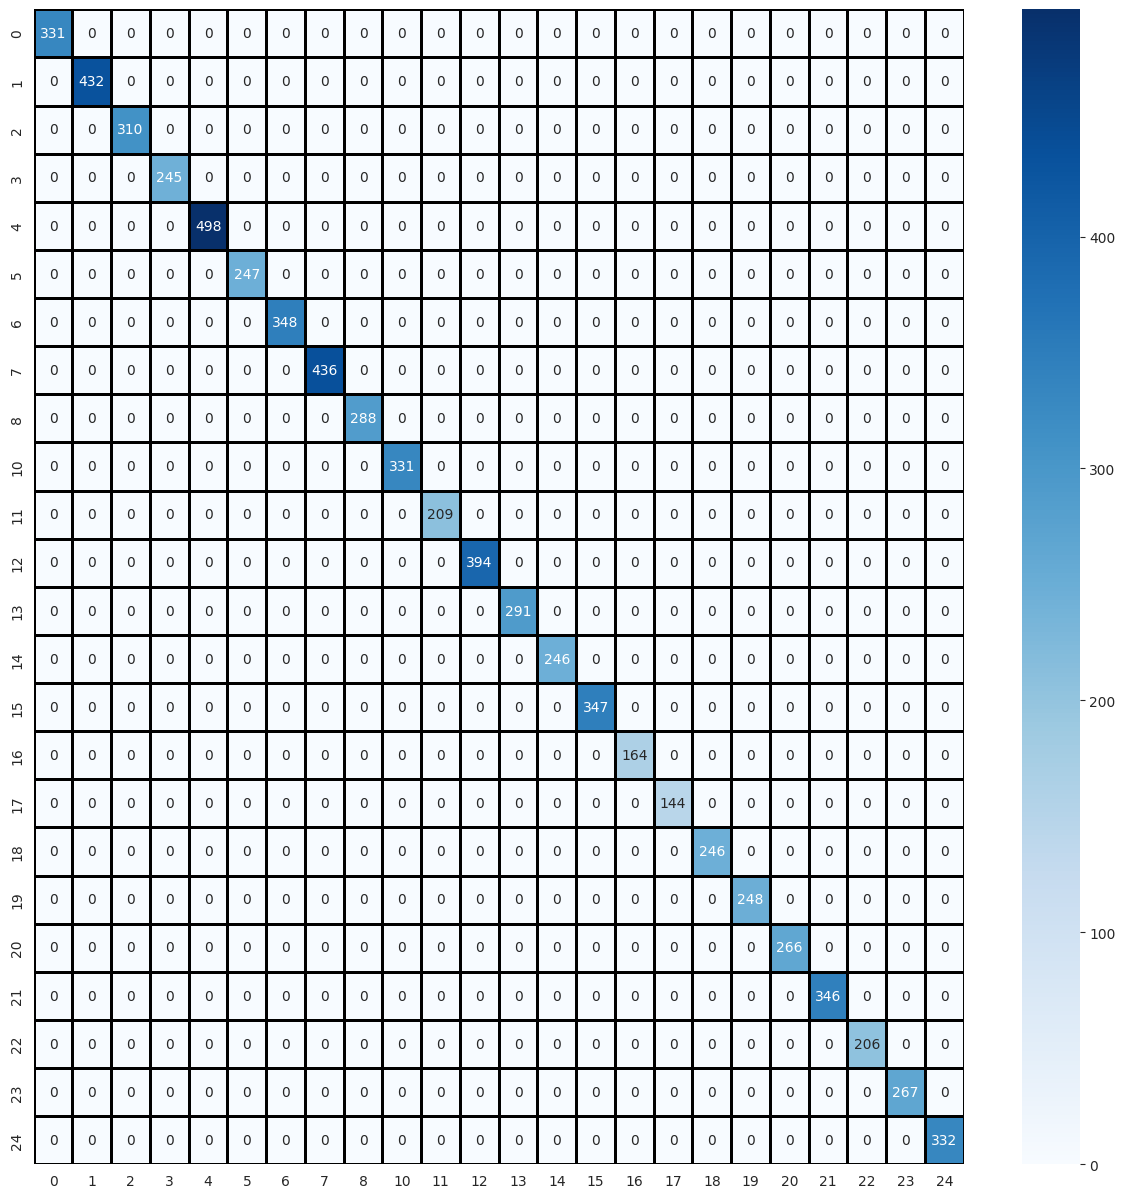

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
correct = np.nonzero(predictions == y.values.tolist())[0]

Посмотрим на работу на некоторых данных

<ipython-input-62-65d3d49c5c14>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


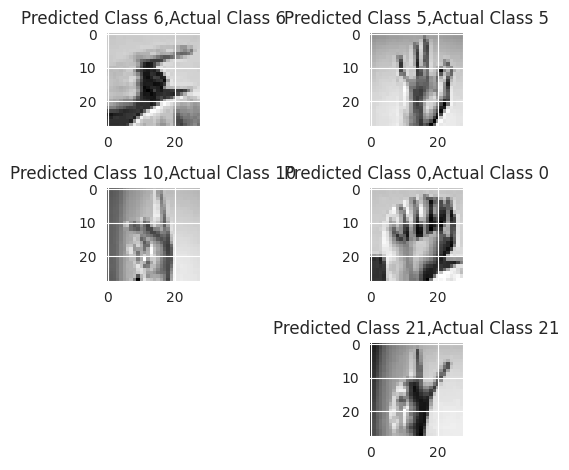

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.imshow(x_test[c].reshape(28,28), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y[c]))
    plt.tight_layout()
    i += 1

# Нейронная сеть на данных American Sign Language Poly (Roboflow)

Для обучения модели выполним следующие шаги:
*   Установим зависимости Detectron2
*   Загрузим датасет из Roboflow.
*   Визуализируем данные обучения Detectron2
*   Напишем нашу конфигурацию обучения Detectron2
*   Запустим обучение Detectron2
*   Оценим производительность Dectron2
*   Напишем нашу конфигурацию обучения Detectron2
*   Запустим вывод Detectron2 на тестовых изображениях
*   Экспортирем сохраненные веса Detectron2 для будущих работ

##Установим зависимости Detectron2

In [1]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.76
    Uninstalling opencv-python-headless-4.8.0.76:
      Successfully uninstalled 

##Загрузим датасет из Roboflow.

In [2]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

In [3]:
VERSION = 2
rf = Roboflow(api_key="YiC39I6k3QXh8L8mRo8j")
project = rf.workspace("team-roboflow").project("american-sign-language-poly")
dataset = project.version(VERSION).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to American-Sign-Language-Poly-2 in coco:: 100%|██████████| 1679/1679 [00:00<00:00, 2059.72it/s]


In [4]:
register_coco_instances("asl_poly_train", {}, f"./American-Sign-Language-Poly-{VERSION}/train/_annotations.coco.json", f"./American-Sign-Language-Poly-{VERSION}/train/")
register_coco_instances("asl_poly_valid", {}, f"./American-Sign-Language-Poly-{VERSION}/valid/_annotations.coco.json", f"./American-Sign-Language-Poly-{VERSION}/valid/")
register_coco_instances("asl_poly_test", {}, f"./American-Sign-Language-Poly-{VERSION}/test/_annotations.coco.json", f"./American-Sign-Language-Poly-{VERSION}/test/")

Визуализируем данные обучения Detectron2


WARNING [09/14 18:54:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/14 18:54:39 d2.data.datasets.coco]: Loaded 1503 images in COCO format from ./American-Sign-Language-Poly-2/train/_annotations.coco.json


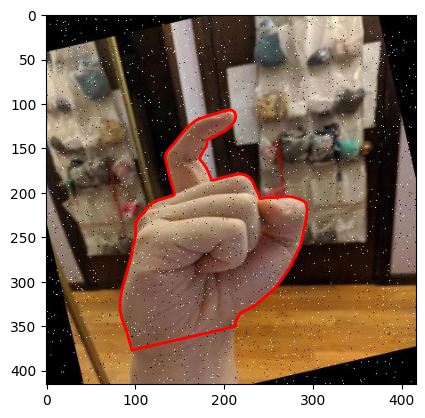

In [5]:
dataset_train = DatasetCatalog.get("asl_poly_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

##Напишем нашу конфигурацию обучения Detectron2


In [6]:
cfg = get_cfg()
#cfg.MODEL.DEVICE = 'cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("asl_poly_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("asl_poly_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 27 # 26 letters plus one super class
cfg.TEST.EVAL_PERIOD = 0 # Increase this number if you want to monitor validation performance during training

PATIENCE = 500 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

##Запустим обучение Detectron2


In [7]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[09/14 18:54:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 96.6MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


WARNING [09/14 18:54:54 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/14 18:54:54 d2.data.datasets.coco]: Loaded 1503 images in COCO format from ./American-Sign-Language-Poly-2/train/_annotations.coco.json
[09/14 18:54:54 d2.data.build]: Removed 0 images with no usable annotations. 1503 images left.
[09/14 18:54:54 d2.data.build]: Distribution of instances among all 27 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   Signs    | 0            |     A      | 51           |     B      | 48           |
|     C      | 60           |     D      | 63           |     E      | 51           |
|     F      | 48           |     G      | 69           |     H      | 60           |
|     I      | 54           |     J      | 78           |     K      | 63           |
|     L      | 60           

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)


[09/14 18:55:11 d2.utils.events]:  iter: 19  total_loss: 4.433  loss_cls: 3.566  loss_box_reg: 0.1413  loss_mask: 0.6944  loss_rpn_cls: 0.01023  loss_rpn_loc: 0.007223     lr: 4.9953e-06  max_mem: 1769M
[09/14 18:55:24 d2.utils.events]:  eta: 1:50:35  iter: 39  total_loss: 4.217  loss_cls: 3.346  loss_box_reg: 0.138  loss_mask: 0.6932  loss_rpn_cls: 0.01006  loss_rpn_loc: 0.005111     lr: 9.9902e-06  max_mem: 1769M
[09/14 18:55:31 d2.utils.events]:  eta: 0:55:36  iter: 59  total_loss: 3.638  loss_cls: 2.758  loss_box_reg: 0.1598  loss_mask: 0.6921  loss_rpn_cls: 0.007539  loss_rpn_loc: 0.006001     lr: 1.4985e-05  max_mem: 1769M
[09/14 18:55:38 d2.utils.events]:  eta: 0:56:08  iter: 79  total_loss: 2.785  loss_cls: 1.945  loss_box_reg: 0.1438  loss_mask: 0.6926  loss_rpn_cls: 0.009349  loss_rpn_loc: 0.006495     lr: 1.998e-05  max_mem: 1770M
[09/14 18:55:44 d2.utils.events]:  eta: 0:56:16  iter: 99  total_loss: 1.71  loss_cls: 0.8425  loss_box_reg: 0.1487  loss_mask: 0.6909  loss_rpn_c

OrderedDict([('bbox',
              {'AP': 74.9040506466613,
               'AP50': 90.30194090837657,
               'AP75': 90.30194090837657,
               'APs': nan,
               'APm': nan,
               'APl': 74.9040506466613,
               'AP-Signs': nan,
               'AP-A': 57.72277227722772,
               'AP-B': 90.0,
               'AP-C': 80.0,
               'AP-D': 78.44059405940594,
               'AP-E': 85.04950495049505,
               'AP-F': 67.51650165016503,
               'AP-G': 80.0,
               'AP-H': 83.86138613861385,
               'AP-I': 73.9002828854314,
               'AP-J': 69.47194719471946,
               'AP-K': 80.0,
               'AP-L': 90.0,
               'AP-M': 70.0,
               'AP-N': 44.476800621238596,
               'AP-O': 70.89108910891089,
               'AP-P': nan,
               'AP-Q': 60.29702970297029,
               'AP-R': 90.0,
               'AP-S': 90.0,
               'AP-T': 50.79207920792079,
       

In [26]:
torch.save(model.state_dict(), cfg.OUTPUT_DIR+"/final_model.pth")

##Запустим вывод Detectron2 на тестовых изображениях


In [27]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "final_model.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

dataset_dicts = DatasetCatalog.get("asl_poly_valid")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    im = Image.fromarray(out.get_image()[:, :, ::-1])
    im

[09/14 19:46:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/final_model.pth ...
WARNING [09/14 19:46:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/14 19:46:09 d2.data.datasets.coco]: Loaded 100 images in COCO format from ./American-Sign-Language-Poly-2/valid/_annotations.coco.json


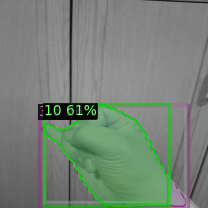

In [28]:
im

Экспортирем сохраненные веса Detectron2 для будущих работ

In [30]:
from google.colab import files
files.download(os.path.join(cfg.OUTPUT_DIR, "final_model.pth"))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>